In [7]:
import numpy as np
import pandas as pd

import warnings
import matplotlib.pyplot as plt
from matplotlib.pyplot import subplots
import matplotlib.patches as patches
import seaborn as sns

from pylab import rcParams

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_squared_error

import eli5
import os
from tqdm import tqdm
import gc
import random    
import math
import psutil
import pickle
import datetime



In [11]:
warnings.filterwarnings('ignore')

root = "../../data/raw/Gamma_Log_Facies_Type_Prediction/"
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.style.use('seaborn')
pd.set_option('max_columns', 150)
# rcParams['figure.figsize'] = 16,8



In [12]:
# Original code from https://www.kaggle.com/gemartin/load-data-reduce-memory-usage by @gemartin
# Modified to support timestamp type, categorical type
# Modified to add option to use float16 or not. feather format does not support float16.
from pandas.api.types import is_datetime64_any_dtype as is_datetime
from pandas.api.types import is_categorical_dtype

def reduce_mem_usage(df, use_float16=False):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        if is_datetime(df[col]) or is_categorical_dtype(df[col]):
            # skip datetime type or categorical type
            continue
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if use_float16 and c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [13]:
%%time
train_df = pd.read_csv(root + "Train_File.csv")
test_df = pd.read_csv(root + "Test_File.csv")
submit_df = pd.read_csv(root + "Submission_File.csv")

CPU times: user 2.83 s, sys: 493 ms, total: 3.32 s
Wall time: 3.36 s


In [14]:
%time
reduce_mem_usage(train_df, use_float16=True);
reduce_mem_usage(test_df, use_float16=True);

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 6.2 µs
Memory usage of dataframe is 134.28 MB
Memory usage after optimization is: 29.37 MB
Decreased by 78.1%
Memory usage of dataframe is 67.14 MB
Memory usage after optimization is: 117.77 MB
Decreased by -75.4%


In [15]:
train_df.head()

,row_id,well_id,GR,label
0,0,0,143.5000,0
1,1,0,112.8125,0
2,2,0,123.5625,0
3,3,0,111.6875,0
4,4,0,123.6250,0


In [16]:
test_df.head()

,unique_id,row_id,well_id,GR
0,CAX_0,0,5000,113.9375
1,CAX_1,1,5000,120.8750
2,CAX_2,2,5000,115.3125
3,CAX_3,3,5000,118.8750
4,CAX_4,4,5000,127.7500


In [17]:
train_df.shape, test_df.shape

((4400000, 4), (2200000, 4))

<BarContainer object of 5 artists>

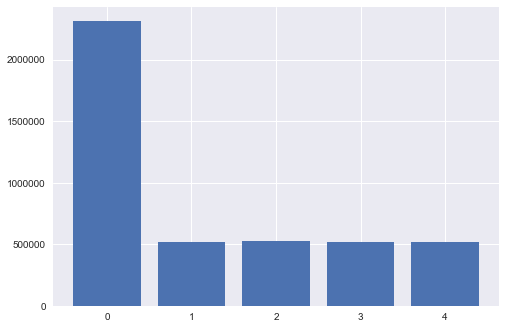

In [18]:
# Количество классов для предсказания

g = train_df["label"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

<BarContainer object of 1100 artists>

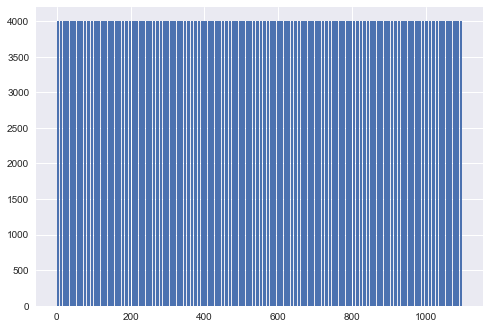

In [10]:
g = train_df["row_id"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

<BarContainer object of 1100 artists>

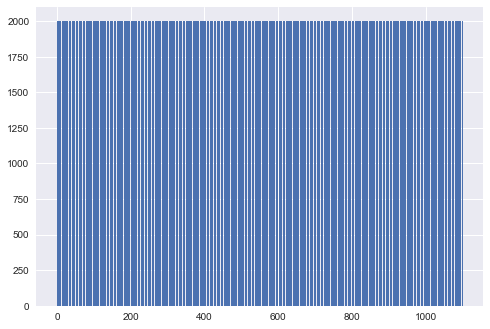

In [11]:
g = test_df["row_id"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

<BarContainer object of 4000 artists>

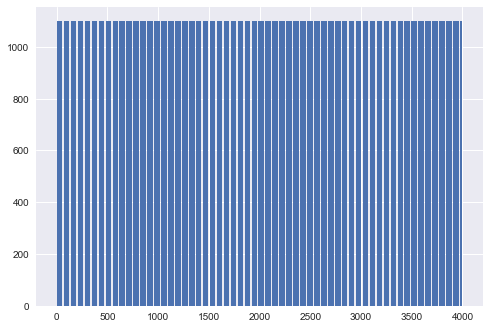

In [12]:
g = train_df["well_id"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

<BarContainer object of 2000 artists>

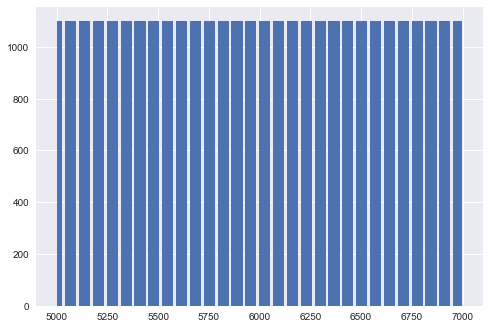

In [13]:
g = test_df["well_id"].value_counts()
g = g.sort_index().T
plt.bar(g.index, g.values)

In [14]:
np.min(train_df["GR"]), np.min(test_df["GR"]), np.max(train_df["GR"]), np.max(test_df["GR"])

(-3.182, -4.93, 197.0, 196.1)

In [15]:
def show_meters(well_id):
    temp_df = train_df[train_df["well_id"]==well_id].reset_index(drop=True)

    fig, axs = plt.subplots(2, 1)
    for i in range(4):
        tdf = temp_df[temp_df["meter"]==i]
        axs[i].scatter(x=tdf["timestamp"][::-1], y=tdf["meter_reading"][::-1])
        axs[i].set_title(subtitles[i])
        axs[i].grid(True)
    fig.tight_layout()
    plt.show()

In [16]:
well_id = 0
temp_df = train_df[train_df["well_id"]==well_id].reset_index(drop=True)
temp_df.shape

(1100, 4)

In [39]:
def show_scatter_layers(well_id):
    temp_df = train_df[train_df["well_id"]==well_id].reset_index(drop=True)
    fig, ax = plt.subplots(figsize=(20, 7))
    plt.scatter(x=temp_df["row_id"][::-1], y=temp_df["GR"][::-1], c=temp_df["label"], cmap='viridis', marker='o')
    plt.title(f"Plot for well {well_id}")
    plt.grid(True)
    plt.show()

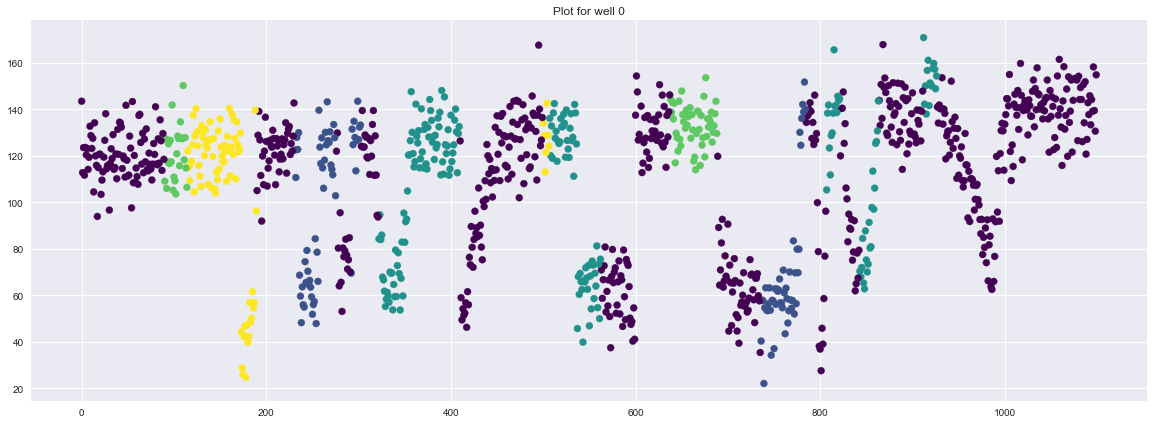

In [40]:
show_scatter_layers(0)

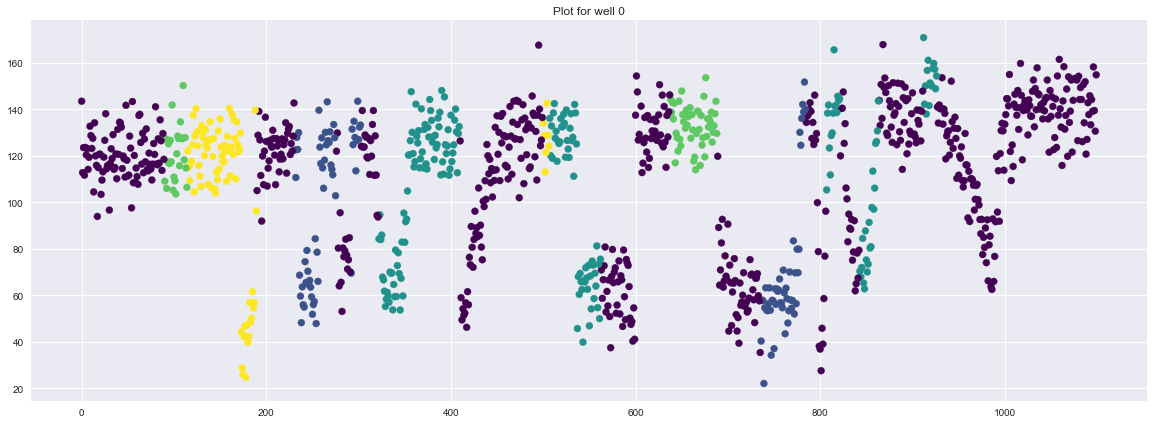

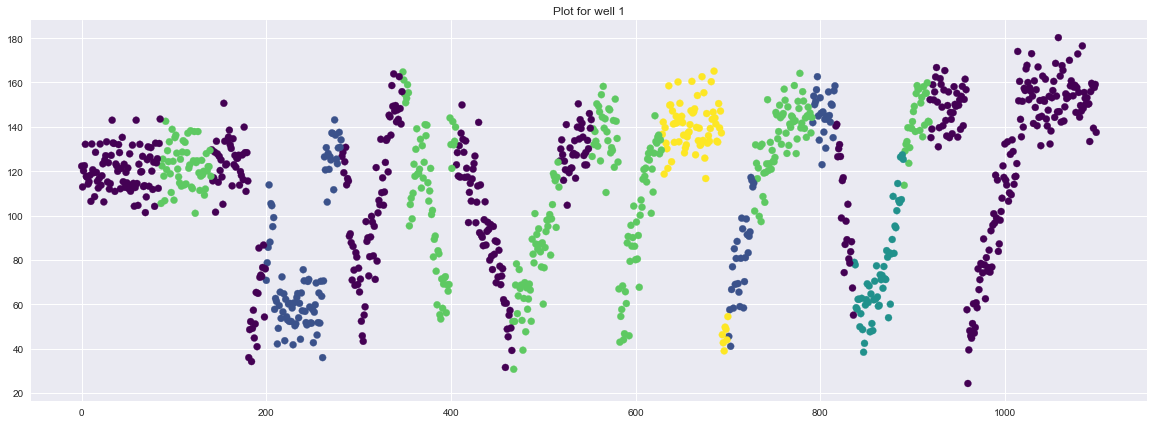

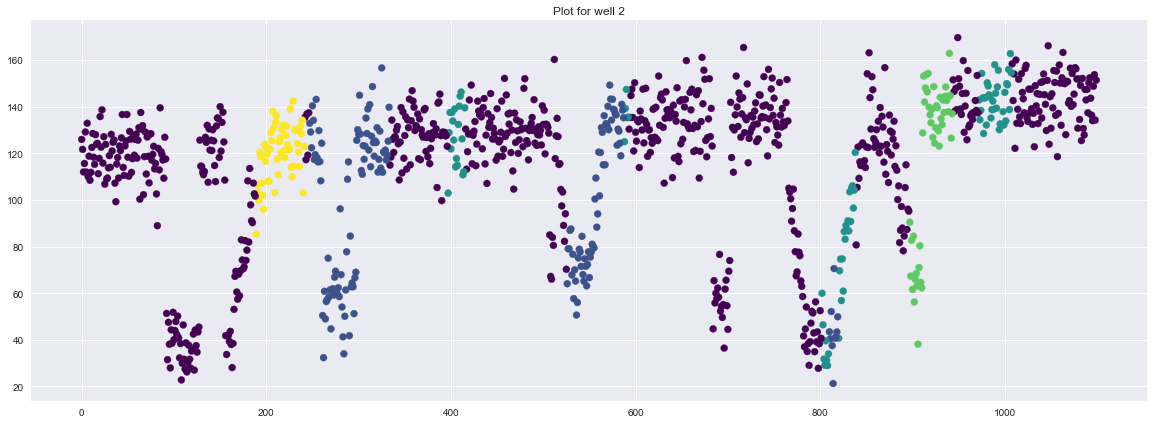

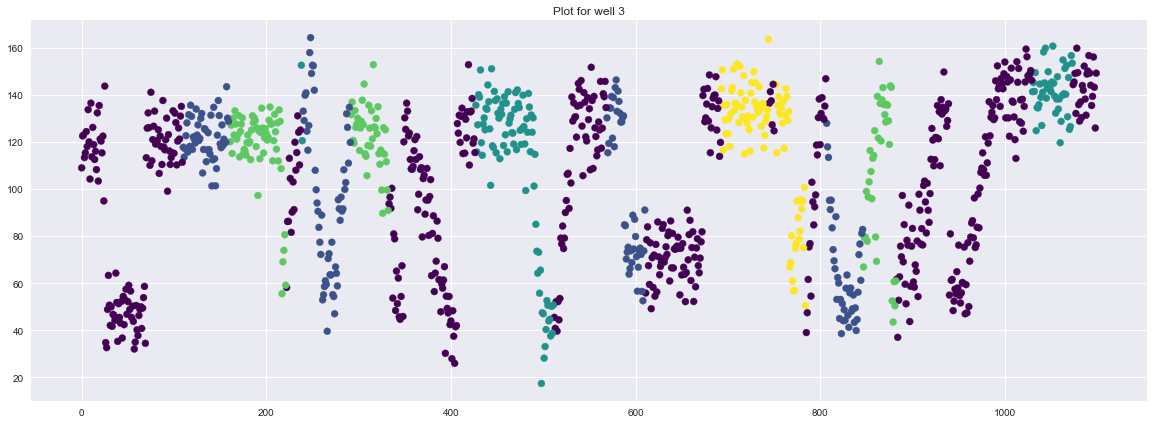

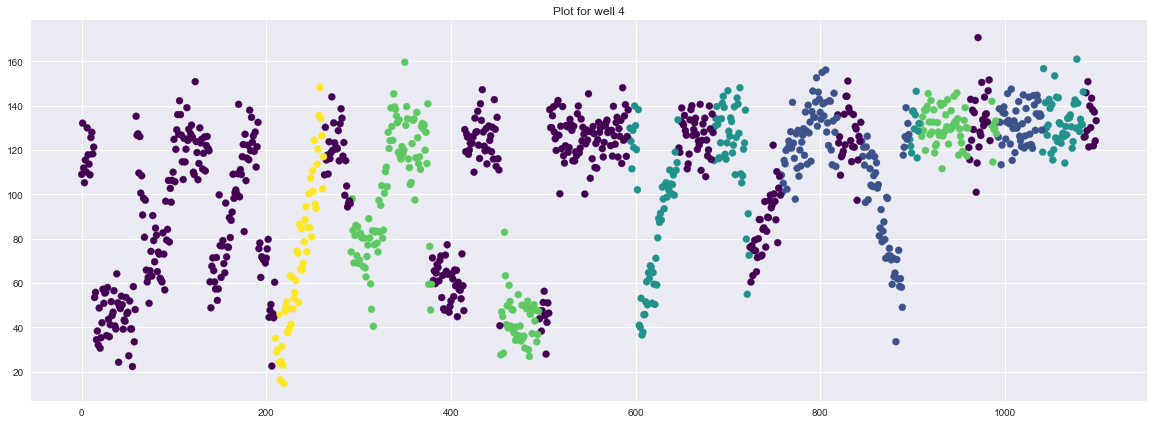

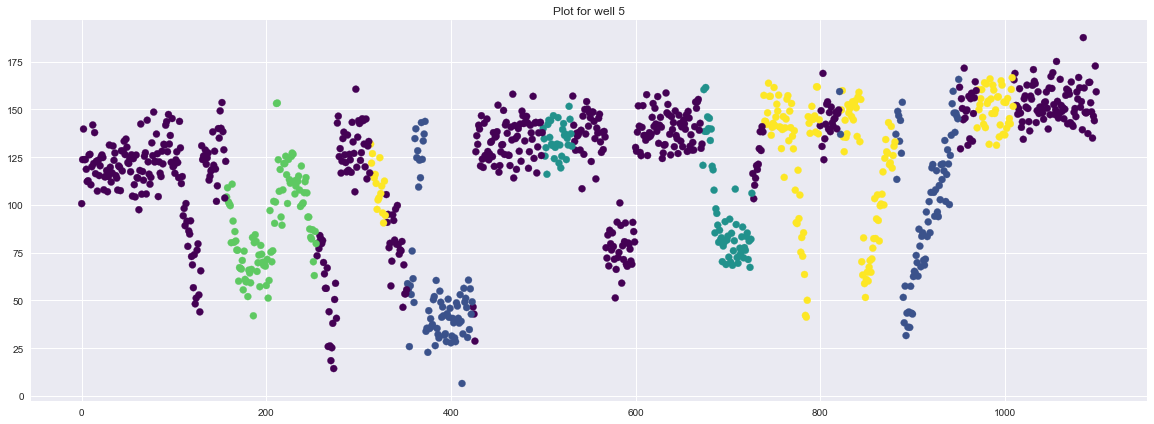

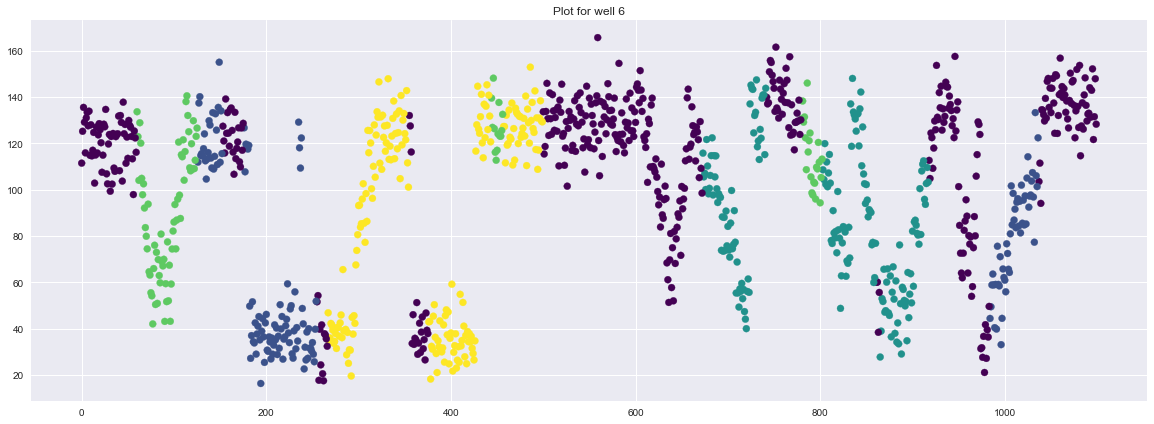

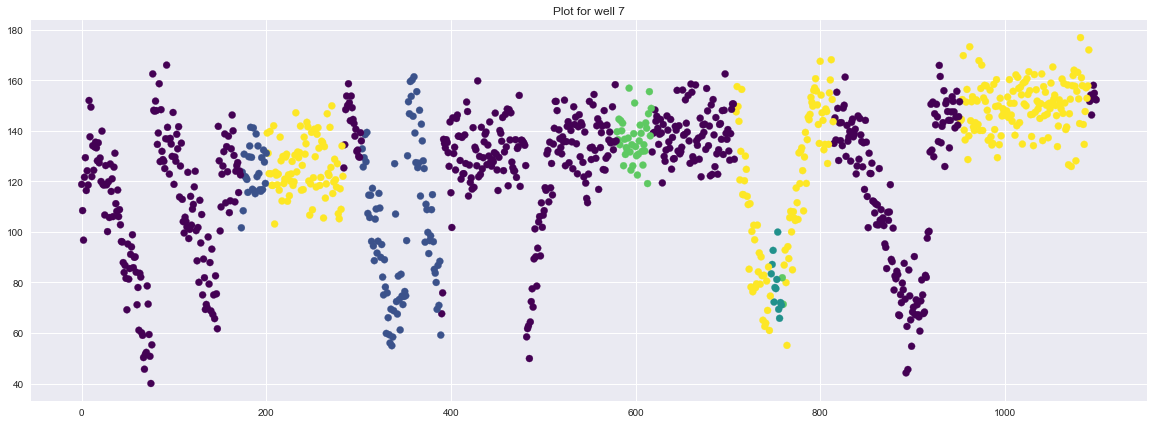

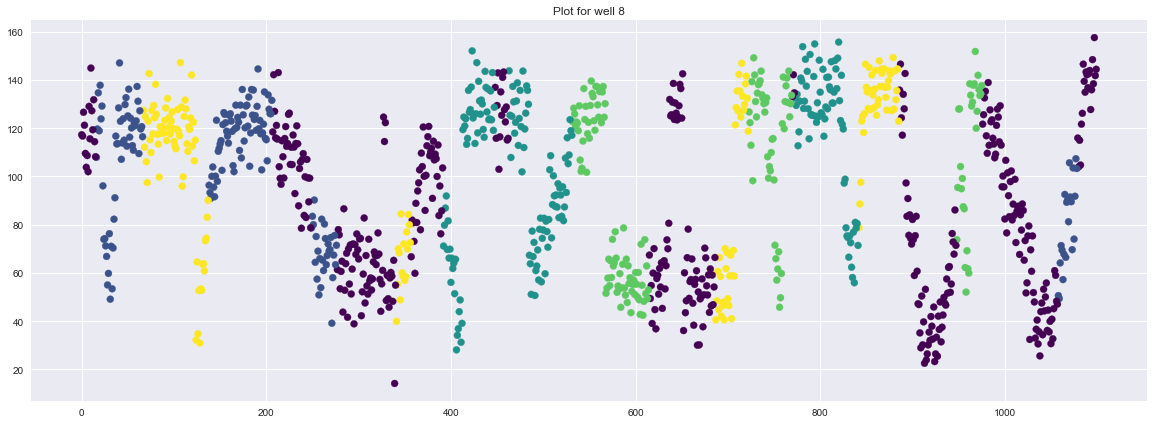

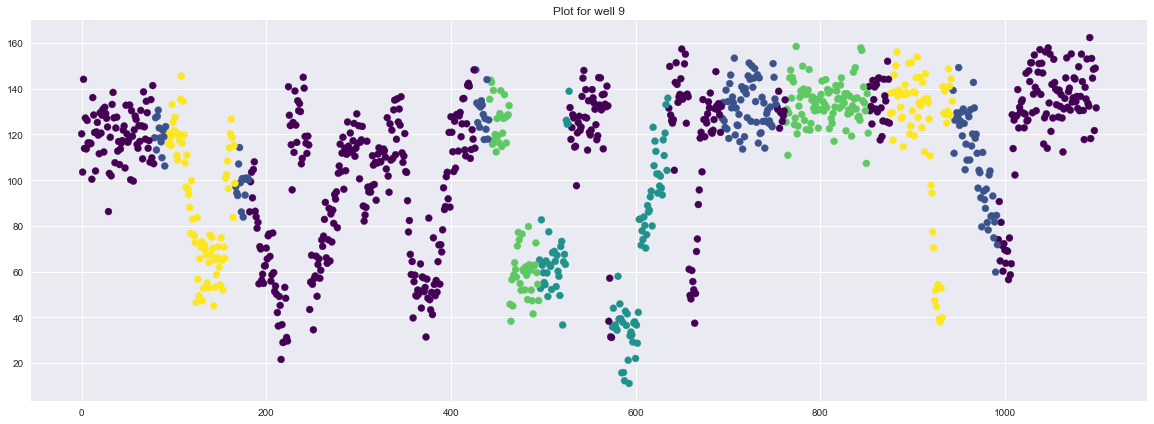

In [42]:
for i in range(10):
    show_scatter_layers(i)

In [46]:
temp_df = train_df[train_df["well_id"]==5].reset_index(drop=True)

In [47]:
temp_df.head()

,row_id,well_id,GR,label
0,0,5,100.6875,0
1,1,5,123.7500,0
2,2,5,139.7500,0
3,3,5,123.7500,0
4,4,5,123.7500,0


In [48]:
temp_df.describe()

,row_id,well_id,GR,label
count,1100.000000,1100.0,1100.000000,1100.000000
mean,549.500000,5.0,inf,1.196364
std,317.686953,0.0,35.468750,1.545661
min,0.000000,5.0,6.519531,0.000000
25%,274.750000,5.0,88.171875,0.000000
50%,549.500000,5.0,125.843750,0.000000
75%,824.250000,5.0,142.750000,2.250000
max,1099.000000,5.0,187.625000,4.000000


In [49]:
temp = train_df.groupby("well_id")

In [54]:
len(temp.groups)

4000

In [59]:
temp.groups[0]

Int64Index([   0,    1,    2,    3,    4,    5,    6,    7,    8,    9,
            ...
            1090, 1091, 1092, 1093, 1094, 1095, 1096, 1097, 1098, 1099],
           dtype='int64', length=1100)

In [65]:
for name, group in temp:
    print(name, group["GR"])

0 0       143.5000
1       112.8125
2       123.5625
3       111.6875
4       123.6250
          ...   
1095    139.1250
1096    158.2500
1097    139.5000
1098    130.6250
1099    154.8750
Name: GR, Length: 1100, dtype: float16
1 1100    122.250
1101    112.875
1102    120.125
1103    122.500
1104    132.125
         ...   
2195    158.750
2196    139.375
2197    157.750
2198    159.125
2199    137.500
Name: GR, Length: 1100, dtype: float16
2 2200    125.9375
2201    121.6875
2202    112.0000
2203    115.6250
2204    129.1250
          ...   
3295    134.0000
3296    148.7500
3297    153.7500
3298    134.2500
3299    151.3750
Name: GR, Length: 1100, dtype: float16
3 3300    109.0000
3301    122.5625
3302    122.9375
3303    113.3750
3304    115.3750
          ...   
4395    139.3750
4396    156.1250
4397    143.2500
4398    125.9375
4399    149.2500
Name: GR, Length: 1100, dtype: float16
4 4400    109.0000
4401    132.1250
4402    111.8750
4403    105.2500
4404    115.5000
          ..